In [1]:
%%capture
!pip install sunpy
!pip install zeep
!pip install drms
!pip install Glymur

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from sunpy.coordinates import frames
from datetime import datetime

In [19]:
import sunpy.map

In [30]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

# Coordinate Example

## General

**A SkyCoord object to represent a point on the Sun can then be created:**

In [8]:
timeNow = str(datetime.utcnow())
timeNow

'2024-01-11 14:37:07.305429'

In [9]:
frameType = frames.HeliographicStonyhurst
frameType

sunpy.coordinates.frames.HeliographicStonyhurst

In [13]:
coordinate = SkyCoord(70*u.deg,-30*u.deg,obstime=timeNow,frame=frameType)
coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2024-01-11T14:37:07.305, rsun=695700.0 km): (lon, lat) in deg
    (70., -30.)>

**tranlating coordinate:**

In [14]:
coordinate = coordinate.transform_to(frames.Helioprojective(observer="earth"))
coordinate

<SkyCoord (Helioprojective: obstime=2024-01-11T14:37:07.305, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (794.9723869, -466.32684788, 1.4689727e+08)>

In [15]:
icrsCoordinate = coordinate.transform_to("icrs")
icrsCoordinate

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (189.57190984, -12.05212544, 1892079.28539689)>

## Earth & Venus

In [16]:
earthObserver = SkyCoord(0*u.deg,0*u.deg,observer="earth",obstime=timeNow,frame=frames.Helioprojective)
earthObserver

<SkyCoord (Helioprojective: obstime=2024-01-11T14:37:07.305, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (0., 0.)>

In [17]:
venusObserver = earthObserver.transform_to(frames.Helioprojective(observer="venus",obstime=timeNow))
venusObserver

<SkyCoord (Helioprojective: obstime=2024-01-11T14:37:07.305, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'venus'>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-1323.45007453, -99.13420476, 0.7219684)>

# Coordinates with Image

## AIA-171 Example

In [20]:
from sunpy.data.sample import AIA_171_IMAGE

In [23]:
AIA_171_IMAGE.name

'AIA20110607_063302_0171_lowres.fits'

In [26]:
aia171Map = sunpy.map.Map(AIA_171_IMAGE)

In [27]:
aia171Map.coordinate_frame

<Helioprojective Frame (obstime=2011-06-07T06:33:02.770, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00406308, 0.04787238, 1.51846026e+11)>)>

In [28]:
coordinate = SkyCoord(80*u.arcsec,10*u.arcsec,frame=aia171Map.coordinate_frame)
coordinate

<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00406308, 0.04787238, 1.51846026e+11)>): (Tx, Ty) in arcsec
    (80., 10.)>

**pair of pixels:**

In [29]:
pixels = aia171Map.wcs.world_to_pixel(coordinate)
pixels

(array(543.4444239), array(515.16250016))

**figure:**

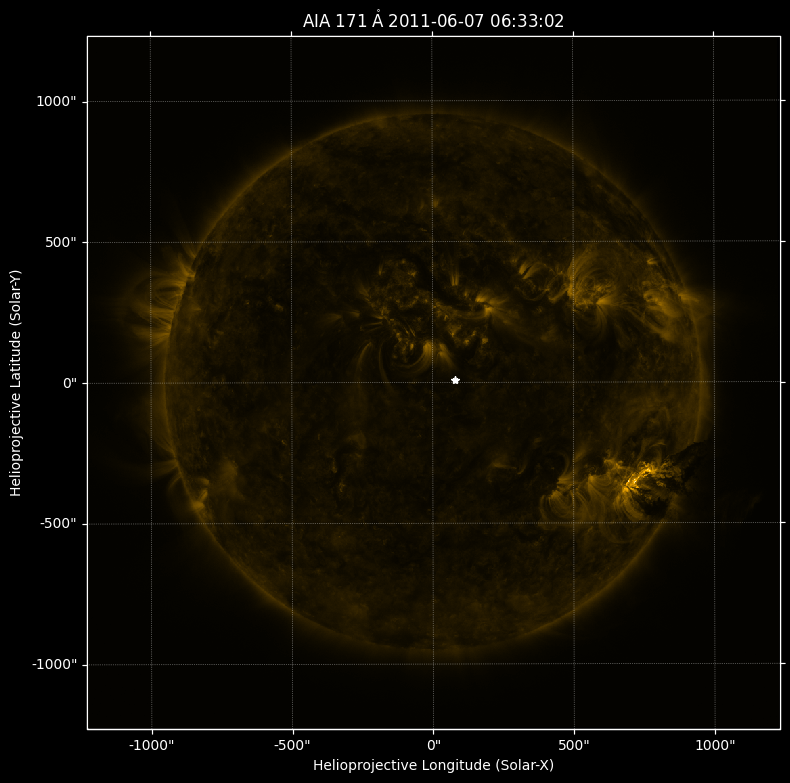

In [34]:
figure = plt.figure(figsize=(8,8))
axs = plt.subplot(111,projection=aia171Map)
aia171Map.plot()
axs.plot_coord(coordinate,"*",color="white")
plt.tight_layout()
plt.show()

# Data Searching & Downloading

In [37]:
from sunpy.net import Fido,attrs as a
import drms

In [ ]:
#print(a.jsoc.Series)

In [38]:
drmsClient = drms.Client()

**key search:**

In [39]:
print(drmsClient.pkeys("hmi.m_720s"))

['T_REC', 'CAMERA']


**segmentation search:**

In [50]:
hmiInformation = drmsClient.info("hmi.sharp_720s")
print(hmiInformation.segments.index.values)

['magnetogram' 'bitmap' 'Dopplergram' 'continuum' 'inclination' 'azimuth'
 'field' 'vlos_mag' 'dop_width' 'eta_0' 'damping' 'src_continuum'
 'src_grad' 'alpha_mag' 'chisq' 'conv_flag' 'info_map' 'confid_map'
 'inclination_err' 'azimuth_err' 'field_err' 'vlos_err' 'alpha_err'
 'field_inclination_err' 'field_az_err' 'inclin_azimuth_err'
 'field_alpha_err' 'inclination_alpha_err' 'azimuth_alpha_err' 'disambig'
 'conf_disambig']


## Time-based

In [42]:
timeInterval = a.Time("2014-01-11T00:00:00","2014-01-11T01:00:00")

In [43]:
searchResult = Fido.search(timeInterval,a.jsoc.Series("hmi.v_45s"))

In [ ]:
#searchResult

In [62]:
searchResult = Fido.search(
    timeInterval | a.Time("2014-01-11T01:00:00","2014-01-11T02:00:00"),
    a.jsoc.Series("hmi.v_45s")
)

In [ ]:
#searchResult

## Parameter-based

In [45]:
result = Fido.search(
    timeInterval,
    a.jsoc.Series("aia.lev1_euv_12s"),
    a.Wavelength(304*u.AA)
)

In [ ]:
#result

**optimization:**

In [47]:
a.jsoc.PrimeKey("HARPNUM","4864")

('HARPNUM', '4864')

In [48]:
a.jsoc.PrimeKey("HARPNUM","4864") & a.jsoc.PrimeKey("CAMERA","2")

<AttrAnd([<sunpy.net.jsoc.attrs.PrimeKey object at 0x7ff001a7d330>
('HARPNUM', '4864'), <sunpy.net.jsoc.attrs.PrimeKey object at 0x7ff001a7f460>
('CAMERA', '2')])>

**keyword search:**

In [ ]:
#result.show("TELESCOP","INSTRUME","T_OBS")

**segmentation search:**

In [51]:
hmiInformation = drmsClient.info("hmi.sharp_720s")
print(hmiInformation.segments.index.values)

['magnetogram' 'bitmap' 'Dopplergram' 'continuum' 'inclination' 'azimuth'
 'field' 'vlos_mag' 'dop_width' 'eta_0' 'damping' 'src_continuum'
 'src_grad' 'alpha_mag' 'chisq' 'conv_flag' 'info_map' 'confid_map'
 'inclination_err' 'azimuth_err' 'field_err' 'vlos_err' 'alpha_err'
 'field_inclination_err' 'field_az_err' 'inclin_azimuth_err'
 'field_alpha_err' 'inclination_alpha_err' 'azimuth_alpha_err' 'disambig'
 'conf_disambig']


In [53]:
search = Fido.search(
    timeInterval,
    a.jsoc.Series("hmi.sharp_720s"),
    a.jsoc.Segment("bitmap")
)

In [ ]:
#search.show()

In [55]:
search = Fido.search(
    timeInterval,
    a.jsoc.Series("hmi.sharp_720s"),
    a.jsoc.Segment("continuum")&a.jsoc.Segment("magnetogram")
)

In [ ]:
#search.show()

In [56]:
search = Fido.search(
    timeInterval,
    a.jsoc.Series("hmi.sharp_720s"),
    a.jsoc.Keyword("bitmap_bzero")==0
)

**complex query:**

In [60]:
search = Fido.search(
    timeInterval,
    a.jsoc.Series("hmi.v_45s") | a.jsoc.Series("aia.lev1_euv_12s")
)

In [ ]:
#search

## Sample-based

In [57]:
result = Fido.search(
    timeInterval,
    a.jsoc.Series("hmi.v_45s"),
    a.Sample(10*u.min)
)

In [58]:
result

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str23,str7,str10,float64,int64
2014.01.11_00:00:45_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145
2014.01.11_00:10:30_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145
2014.01.11_00:20:15_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145
2014.01.11_00:30:00_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145
2014.01.11_00:39:45_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145
2014.01.11_00:49:30_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145
2014.01.11_00:59:15_TAI,SDO/HMI,HMI_FRONT2,6173.0,2145


## Downloading

for use `a.jsoc.Notify()`, please register: http://jsoc.stanford.edu/ajax/register_email.html

In [65]:
from sunpy.net import jsoc

In [63]:
search = Fido.search(
    timeInterval,
    a.jsoc.Series("hmi.v_45s") | a.jsoc.Series("aia.lev1_euv_12s"),
    a.jsoc.Notify("luxspacescience@protonmail.com")
)

In [ ]:
#search.show()

In [66]:
client = jsoc.JSOCClient()

In [67]:
requestsResult = client.search(a.Time("2014-01-01T00:00:00","2014-01-01T01:00:00"),
                         a.jsoc.Series("aia.lev1_euv_12s"),
                         a.jsoc.Notify("luxspacescience@protonmail.com"))

In [ ]:
#requestsResult.show()

In [70]:
request = client.request_data(requestsResult)
print(request)

<ExportRequest: id=JSOC_20240111_1720, status=2>


**once the status code is 0 you can download the data:**

In [72]:
#result = client.get_request(request)
#result.wait(progress=True)